In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [9]:
y_train.shape

(64, 7)

In [10]:
X_test.shape

(64, 48, 48, 1)

In [11]:
y_test.shape

(64, 7)

In [12]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


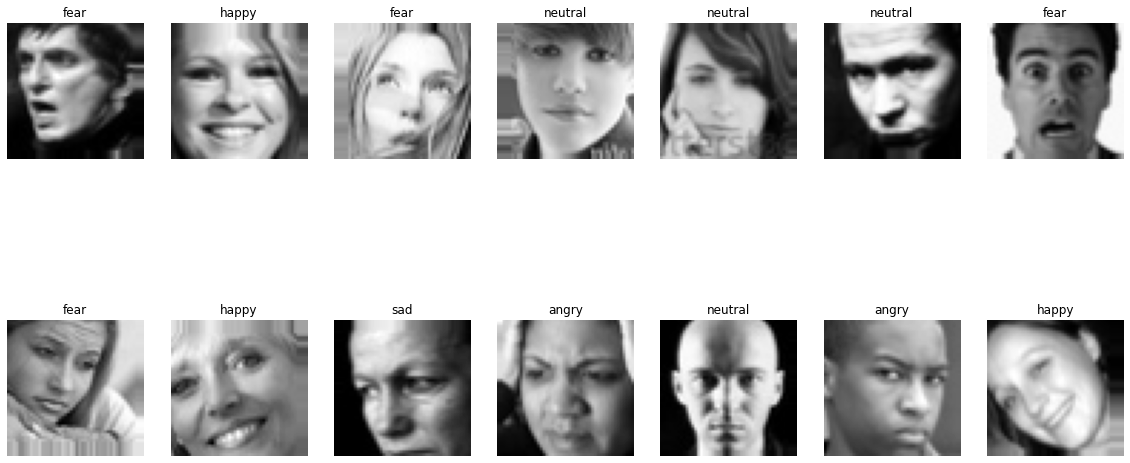

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [14]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [15]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [16]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [18]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [20]:
model = ResNet34(shape = (48, 48, 1), classes = 7)

epochs = 60
batch_size = 64
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 7, 7, 128)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_11

 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 4, 4, 256)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 4, 4, 256)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_21[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_28 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_31 (Conv2D)             (None, 2, 2, 512)    131584      ['activation_26[0][0]']          
                                                                                                  
 add_13 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_28[0][0]', 
                                                                  'conv2d_31[0][0]']              
                                                                                                  
 activation_28 (Activation)     (None, 2, 2, 512)    0           ['add_13[0][0]']                 
          

In [24]:
learning_rate = 0.001
decay_rate = learning_rate / 25
# momentum = 0.8
opt = Adam(learning_rate=learning_rate,  decay=decay_rate)


model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [25]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = 200,batch_size=batch_size,validation_data = validation_generator)

Epoch 1/200
359/359 [==============================] - 173s 464ms/step - loss: 1.7241 - accuracy: 0.3056 - val_loss: 2.3251 - val_accuracy: 0.2975
Epoch 2/200
359/359 [==============================] - 159s 442ms/step - loss: 1.5659 - accuracy: 0.3801 - val_loss: 1.6909 - val_accuracy: 0.3715
Epoch 3/200
359/359 [==============================] - 159s 442ms/step - loss: 1.4832 - accuracy: 0.4183 - val_loss: 1.6791 - val_accuracy: 0.3303
Epoch 4/200
359/359 [==============================] - 159s 442ms/step - loss: 1.4281 - accuracy: 0.4407 - val_loss: 1.6216 - val_accuracy: 0.3513
Epoch 5/200
359/359 [==============================] - 159s 442ms/step - loss: 1.4033 - accuracy: 0.4533 - val_loss: 1.7283 - val_accuracy: 0.4127
Epoch 6/200
359/359 [==============================] - 158s 441ms/step - loss: 1.3382 - accuracy: 0.4829 - val_loss: 1.4138 - val_accuracy: 0.4700
Epoch 7/200
359/359 [==============================] - 159s 442ms/step - loss: 1.3084 - accuracy: 0.4913 - val_loss: 1

Epoch 112/200
359/359 [==============================] - 59s 165ms/step - loss: 0.2706 - accuracy: 0.9026 - val_loss: 1.6685 - val_accuracy: 0.6292
Epoch 113/200
359/359 [==============================] - 59s 164ms/step - loss: 0.2667 - accuracy: 0.9037 - val_loss: 1.7219 - val_accuracy: 0.6082
Epoch 114/200
359/359 [==============================] - 59s 164ms/step - loss: 0.2680 - accuracy: 0.9035 - val_loss: 1.6172 - val_accuracy: 0.6208
Epoch 115/200
359/359 [==============================] - 59s 165ms/step - loss: 0.2497 - accuracy: 0.9115 - val_loss: 1.5529 - val_accuracy: 0.6425
Epoch 116/200
359/359 [==============================] - 59s 165ms/step - loss: 0.2558 - accuracy: 0.9069 - val_loss: 1.6390 - val_accuracy: 0.6313
Epoch 117/200
359/359 [==============================] - 59s 164ms/step - loss: 0.2509 - accuracy: 0.9088 - val_loss: 1.7297 - val_accuracy: 0.6006
Epoch 118/200
359/359 [==============================] - 59s 164ms/step - loss: 0.2831 - accuracy: 0.8966 - val_

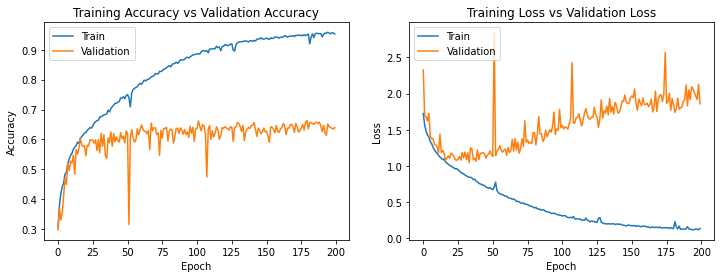

In [26]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [27]:
model.save('Resnet.h5')
model.save_weights('Resnet_weights.h5')

In [28]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 3s 112ms/step - loss: 1.8579 - accuracy: 0.6397
final train accuracy = 94.36 , validation accuracy = 63.97


23/23 [==============================] - 3s 51ms/step
Confusion Matrix
[[28  1 23 44 40 26 29]
 [ 2  0  2  5  2  7  4]
 [18  3 19 52 40 46 26]
 [52  3 36 68 55 87 53]
 [34  3 30 65 43 47 24]
 [35  6 39 56 45 39 29]
 [22  3 26 43 30 29 13]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.15      0.15       191
     disgust       0.00      0.00      0.00        22
        fear       0.11      0.09      0.10       204
       happy       0.20      0.19      0.20       354
     neutral       0.17      0.17      0.17       246
         sad       0.14      0.16      0.15       249
    surprise       0.07      0.08      0.08       166

    accuracy                           0.15      1432
   macro avg       0.12      0.12      0.12      1432
weighted avg       0.15      0.15      0.15      1432



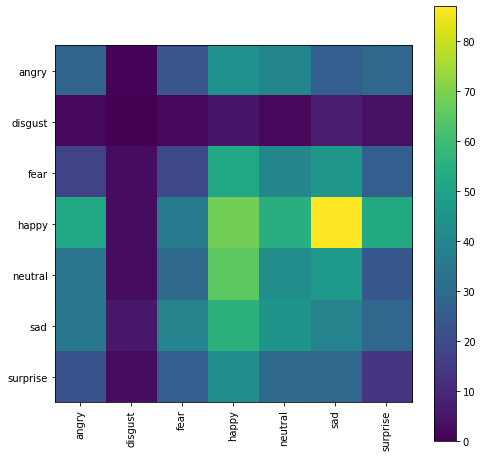

In [29]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 21s 59ms/step
Confusion Matrix
[[ 438   56  460  752  551  574  365]
 [  54    4   57   91   48   60   35]
 [ 442   64  453  833  544  577  365]
 [ 846   77  762 1422  970 1039  656]
 [ 553   60  539  966  673  731  450]
 [ 500   63  537  973  673  694  424]
 [ 348   38  365  629  408  461  288]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3196
     disgust       0.01      0.01      0.01       349
        fear       0.14      0.14      0.14      3278
       happy       0.25      0.25      0.25      5772
     neutral       0.17      0.17      0.17      3972
         sad       0.17      0.18      0.17      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



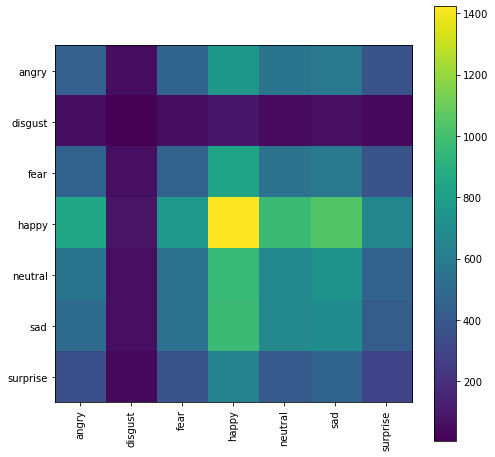

In [30]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [6]:
model = tf.keras.models.load_model('Resnet.h5')

In [7]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 54ms/step - loss: 1.8579 - accuracy: 0.6397
final train accuracy = 94.34 , validation accuracy = 63.97


In [8]:
train_generator.reset()
X_train, y_train = next(train_generator)
for i in range(int(len(train_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(22968, 48, 48, 1) (22968, 7)


In [9]:
validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in range(int(len(validation_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(validation_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

(1432, 48, 48, 1) (1432, 7)


In [10]:
ypred = model.predict(X_train)
ypred = ypred.argmax(axis=-1)


ytrain = y_train.argmax(axis=-1)

718/718 [==============================] - 23s 30ms/step


In [11]:
ypred_test = model.predict(X_test)
ypred_test = ypred_test.argmax(axis=-1)



ytest = y_test.argmax(axis=-1)


45/45 [==============================] - 2s 35ms/step


ROC AUC score: 0.9692827189908996


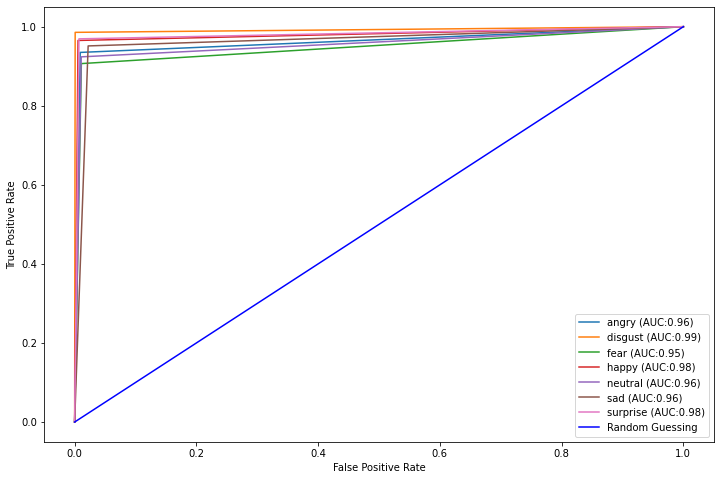

In [12]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['angry', 'disgust', 'fear', 'happy', 'neutral',
          'sad', 'surprise']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.7770129368795123


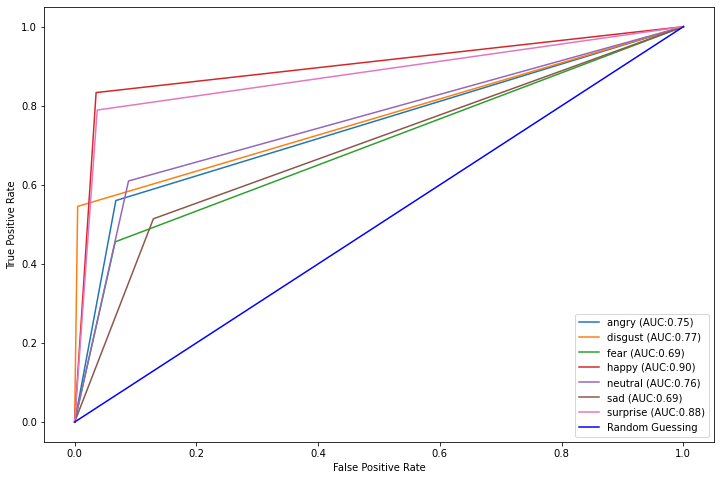

In [13]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytest, ypred_test))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()